# Data Loading Pipelines

Goal: Implement efficient pipeline to load in .jpeg video frames as arrays

# DALI

Resources:

- https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/sequence_processing/sequence_reader_simple_example.html

In [1]:
import os.path
import numpy as np
import shutil

from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [21]:
@pipeline_def
def frame_seq_pipe(path):
    video = fn.readers.sequence(file_root=path, sequence_length=sequence_length)
    return video

def show_sequence(sequence, sequence_length):
    columns = 5
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize = (32, (16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(sequence[j])

In [3]:
data_dir = "/mount/data/dali_frames" #video frame directory

batch_size = 1 #include a single batch of all 364 of our videos
sequence_length = 461 #each video has 461 frames

In [4]:
pipe = frame_seq_pipe(path=data_dir, batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()

In [18]:
import time

ITER = 366 #365 #why do we need to call iter?
all_videos = []

start = time.time()
for i in range(ITER):
    
    if i % 25 == 0:
        print(f'Video {i}')
    
    pipe_out = pipe.run()
    sequences_out = np.array(pipe_out[0][0])
    all_videos.append(sequences_out)
#     print(f"Video {i} shape: {sequences_out.shape}")
#     show_sequence(sequences_out, sequence_length=5)

stop = time.time()
np.array(all_videos).shape

Video 0
Video 25
Video 50
Video 75
Video 100
Video 125
Video 150
Video 175
Video 200
Video 225
Video 250
Video 275
Video 300
Video 325
Video 350


(366, 461, 224, 224, 3)

In [19]:
videos = np.array(all_videos)
videos[0].shape

(461, 224, 224, 3)

### Checking to see if N_ITER wraps around when N_ITER > num. of videos in directory

In [48]:
for i in range(len(videos)):
    curr_frame = videos[i][350]
    for j in range(len(videos)):
        if (curr_frame == videos[j][350]).all() and (i != j):
            print(f'{i} and {j} have the same frame at index 350.')
            
## we have duplicate videos loaded in at index 240, 364, and 365
## 240 might be a pre-existing duplicate in our dataset 
## 364 and 365 are most-likely duplicates based on the N_ITER > 364 and wrapping around
## the last original video loaded in w/o wrapping around has index 363 bc of 0-based indexing (i=363 is the 364th video)

0 and 364 have the same frame at index 350.
1 and 365 have the same frame at index 350.
227 and 240 have the same frame at index 350.
240 and 227 have the same frame at index 350.
364 and 0 have the same frame at index 350.
365 and 1 have the same frame at index 350.


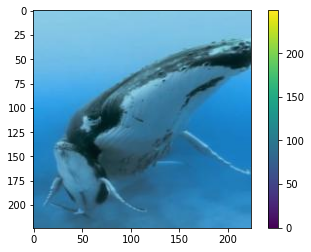

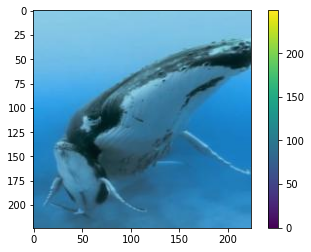

In [94]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(videos[227][350])
plt.colorbar()
plt.grid(False)
plt.show()

plt.figure()
plt.imshow(videos[240][350])
plt.colorbar()
plt.grid(False)
plt.show()

In [62]:
#count of videos in our dataset
import pandas as pd

df = pd.read_csv('/mount/data/downloaded_videos.csv')
df.shape

(364, 12)

In [64]:
#count of videos in our directory (includes one extra)
import os
print(len(next(os.walk('/mount/data/dali_frames'))[1]))

365


In [66]:
#remove the folder with the name that is not in our df
folders = os.listdir('/mount/data/dali_frames')
print(len(folders))

365


In [76]:
true_video_names = list(df['renamed_title'].values)
true_video_names = [name.replace('_', '_clip_').replace('.mp4', '') for name in true_video_names]
true_video_names[0:5]

['video_clip_0000',
 'video_clip_0001',
 'video_clip_0002',
 'video_clip_0003',
 'video_clip_0004']

In [80]:
for video_file in folders:
    if video_file not in true_video_names:
        print(video_file)

.ipynb_checkpoints


In [102]:
df.title.value_counts() > 1

# df[df.title == 'king whale (2021) #shorts']
# df[df.title == 'Follow for more video       #reels  #explorepage #explore #youradventuregram #nature #sea #ocean']

king whale (2021) #shorts                                                                              True
Humpback Whales                                                                                        True
whale sound (2021) #shorts# amazing sound wanle                                                        True
Humpback Whale                                                                                         True
Follow for more video       #reels  #explorepage #explore #youradventuregram #nature #sea #ocean       True
                                                                                                      ...  
Up She rises  Humpback Whale air lifts seagull                                                        False
CIMS Humpback Responds20110731                                                                        False
Kayakers Get the Surprise Of Their Life- Humpback Whale Surprise- Wait For It- Inches From kayaker    False
Humpback whale breach compil

`how does DALI pipelines work for image reading? What are the iterations for?`

`why am I able to go through 365 iterations when I only have 364 videos? Why do we need to iterate? What does pip.run() return?`

# TensorFlow

Resources:
- https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control
- https://learning.oreilly.com/library/view/tensorflow-2-pocket/9781492089179/ch05.html#building_and_training_the_tfdotkeras_mod 

In [37]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [135]:
#create df with image name and label for each frame
frame_names = []
labels = []
for i, row in df.iterrows():
    
    #get label and clip number
    label = row['relevant']
    clip_num = row['renamed_title'].split('_')[1].replace('.mp4', '')
    
    #create list of all frame names
    clip_num_frame_num_names = [f"clip_{clip_num}_frame_{f}.jpg" for f in range(461)]
    
    #add to the list for df creation later
    frame_names += clip_num_frame_num_names
    labels += [str(label) for l in range(461)]
    
#create df
frames_and_labels = pd.DataFrame({"filename": frame_names, "label": labels})
frames_and_labels.shape

(167804, 2)

In [138]:
data_root = "/mount/data/frames"
IMAGE_SIZE = (224,224)
TRAINING_DATA_DIR = str(data_root)
BATCH_SIZE = 32

#input in ImageDataGenerator
datagen_kwargs = dict(rescale=1./255, 
                      validation_split=0.20)

#input in dataflow def
dataflow_kwargs = dict(target_size=IMAGE_SIZE, 
                       batch_size=BATCH_SIZE,
                       interpolation="bilinear")



In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

train_generator = train_datagen.flow_from_dataframe(
                                dataframe=frames_and_labels,
                                directory=data_root,
                                x_col="filename",
                                y_col="label",
                                subset="training",
                                seed=10,
                                shuffle=True,
                                class_mode="binary",
                                **dataflow_kwargs)

In [ ]:
#inspecting the dataset
image_batch, label_batch = next(iter(train_generator))
fig, axes = plt.subplots(8, 4, figsize=(20, 40))
axes = axes.flatten()
for img, lbl, ax in zip(image_batch, label_batch, axes):
    ax.imshow(img)
    label_ = np.argmax(lbl)
    label = idx_labels[label_]
    ax.set_title(label)
    ax.axis('off')
plt.show()